In [ ]:
!pip3 install matplotlib
!pip install opencv-python
!pip install numpy

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Image Size: 730 x 730 pixels


interactive(children=(IntSlider(value=50, description='Gradient Threshold', max=255), IntSlider(value=5, descr…

Button(description='Find Circle', style=ButtonStyle())

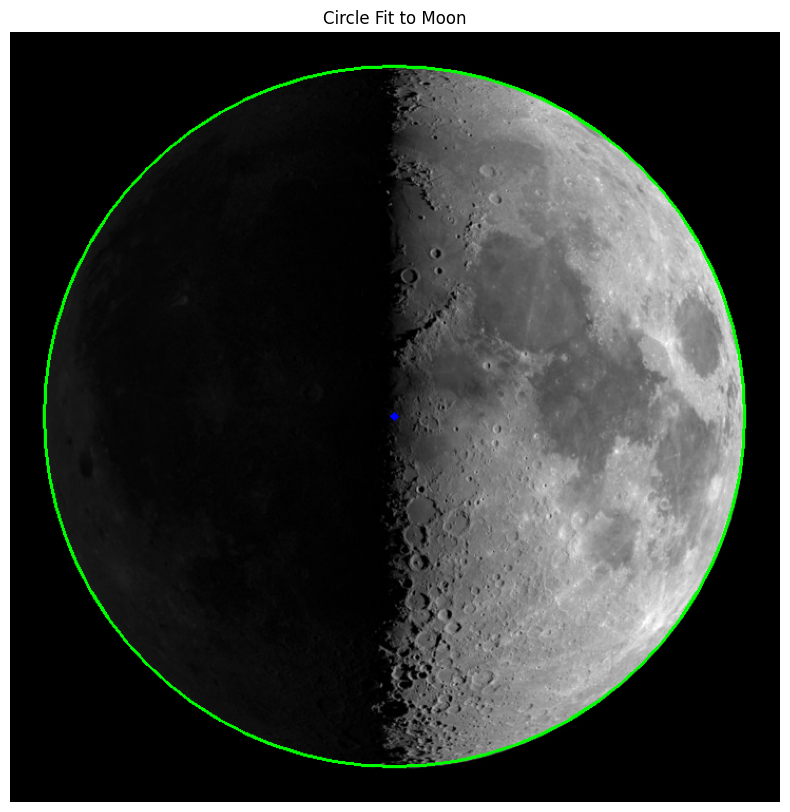

Center: (364.1167510987112, 364.58519410820816)
Radius: 332.73815415257434


In [ ]:
#CIRCLE OUTLINE OF MOON FINDER


import matplotlib.pyplot as plt
import cv2
import numpy as np
from ipywidgets import interact, IntSlider, Button
from scipy.optimize import leastsq

# Load the image
image_path = "/content/drive/MyDrive/The Nueva Physics Research Team/2023-24/The Surface of the Moon/Moon Shots: Date, Version(1,2,3...)/Not our photos/09:22:2023 9PM.jpg"
image1 = cv2.imread(image_path)
if image1 is None:
    print("Error loading image")
    exit()

height, width = image1.shape[:2]
print(f"Image Size: {width} x {height} pixels")


# Function to show edges based on the selected threshold
def show_edges(gradient_threshold, blur_kernel_size):
    gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray1, (blur_kernel_size, blur_kernel_size), 0)
    edges = cv2.Canny(blur, gradient_threshold, gradient_threshold * 2)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(edges, cmap='gray')
    plt.title(f"Edges with threshold: {gradient_threshold}")
    plt.axis('off')

    y, x = np.where(edges > 0)
    plt.subplot(1, 2, 2)
    plt.scatter(x, y, s=1)
    plt.xlim([0, gray1.shape[1]])
    plt.ylim([gray1.shape[0], 0])  # Reverse the y-axis to match image coordinates
    plt.title("Edge Locations")
    plt.xlabel('X coordinate')
    plt.ylabel('Y coordinate')

    plt.tight_layout()
    plt.show()

# Function to find and display the circle
def find_and_show_circle(gradient_threshold, blur_kernel_size):
    gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray1, (blur_kernel_size, blur_kernel_size), 0)
    edges = cv2.Canny(blur, gradient_threshold, gradient_threshold * 2)
    y, x = np.where(edges > 0)
    points = np.c_[x, y]

    M = cv2.moments(edges)
    if M["m00"] != 0:
        centroid_x = int(M["m10"] / M["m00"])
        centroid_y = int(M["m01"] / M["m00"])
    else:
        centroid_x = gray1.shape[1] // 2
        centroid_y = gray1.shape[0] // 2

    initial_radius = np.mean(np.sqrt((x - centroid_x)**2 + (y - centroid_y)**2))

    def calc_R(xc, yc, points):
        return np.sqrt((points[:, 0] - xc) ** 2 + (points[:, 1] - yc) ** 2)

    def f_circle(c, points):
        center = c[:2]
        radius = c[2]
        return calc_R(*center, points) - radius

    center_estimate = centroid_x, centroid_y
    radius_estimate = initial_radius
    initial_guess = center_estimate + (radius_estimate,)

    center, ier = leastsq(f_circle, initial_guess, args=(points,))

    if ier not in [1, 2, 3, 4]:
        print("Optimal parameters not found: " + str(ier))
        return

    xc, yc, R = center

    circle_image = cv2.cvtColor(gray1, cv2.COLOR_GRAY2BGR)
    cv2.circle(circle_image, (int(xc), int(yc)), int(R), (0, 255, 0), 2)
    cv2.circle(circle_image, (int(xc), int(yc)), 2, (0, 0, 255), 3)

    plt.figure(figsize=(10, 10))
    plt.imshow(circle_image)
    plt.title("Circle Fit to Moon")
    plt.axis('off')
    plt.show()

    # Return the center and radius
    return (xc, yc, R)

# Create slider widgets for the interactive components
gradient_threshold_slider = IntSlider(min=0, max=255, step=1, value=50, description='Gradient Threshold')
blur_kernel_size_slider = IntSlider(min=3, max=27, step=2, value=5, description='Blur Kernel Size')

# Function to call when button is clicked, which gets current slider values
def on_button_clicked(b):
    xc, yc, R = find_and_show_circle(gradient_threshold_slider.value, blur_kernel_size_slider.value)
    print(f"Center: ({xc}, {yc})")
    print(f"Radius: {R}")

# Create a button widget
button = Button(description="Find Circle")
button.on_click(on_button_clicked)

# Display the slider and button using interact
interact(show_edges,
         gradient_threshold=gradient_threshold_slider,
         blur_kernel_size=blur_kernel_size_slider)
display(button)


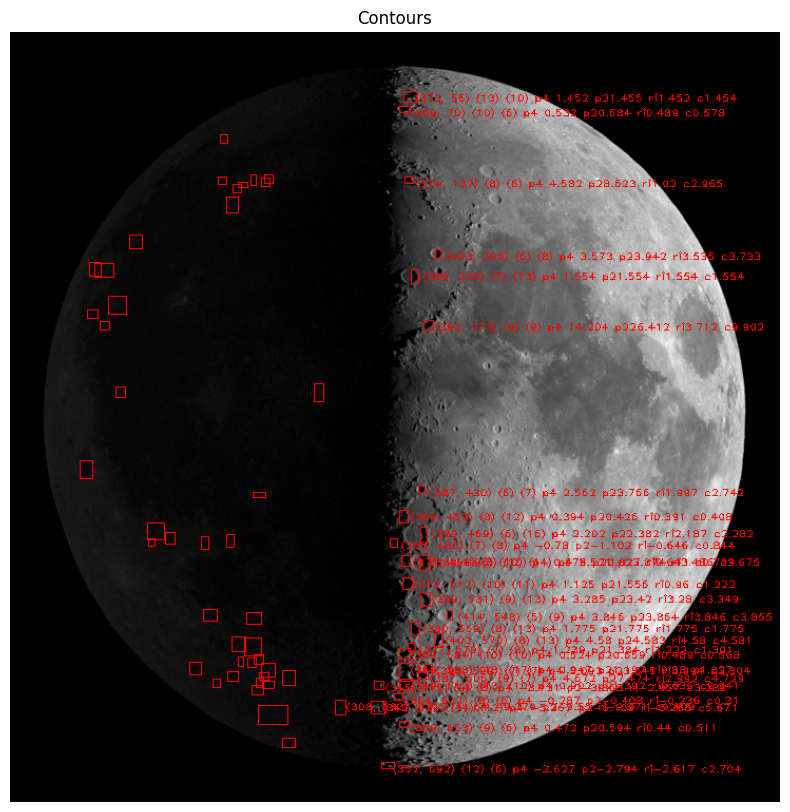

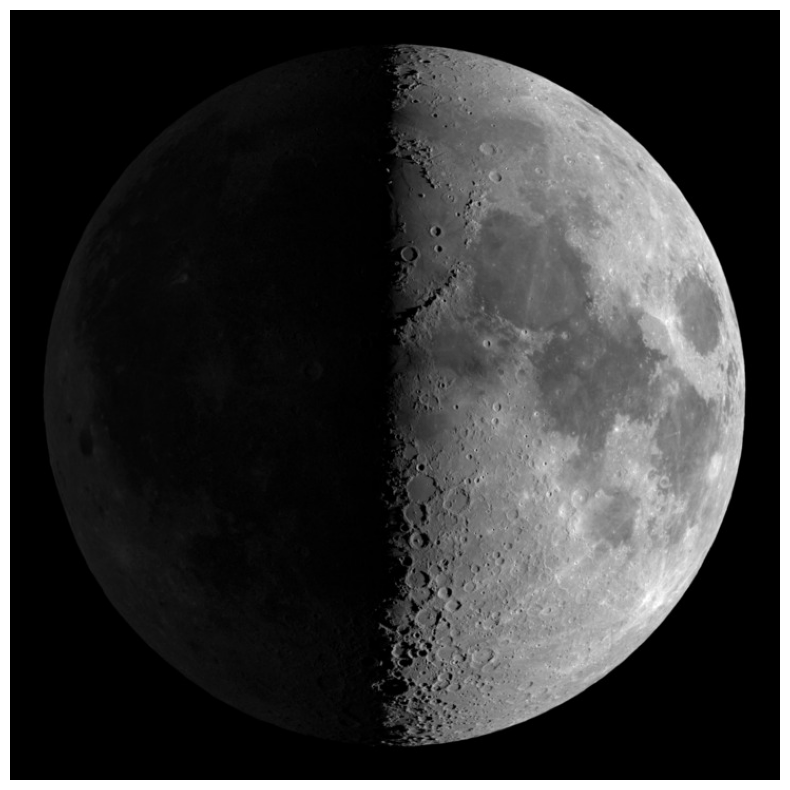

In [ ]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import math
import skimage.draw as ski_draw  # Adjusted for direct access to draw module

def contour_shadows(image_path, R, Center):
    '''contour_shadows(image_path, R, Center) -> None
    Displays images of the moon with contours drawn around shadows and labeled shadow widths for a single image'''

    # Read Image
    image = cv2.imread(image_path)
    if image is None:
        print("Error loading image")
        return  # Exit the function if the image couldn't be loaded

    # Convert Image to Gray
    gray1 = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    rotation_center = (Center)  # Replace x_center and y_center with your values
    rotation_angle = 0
    incident =  1.5707963268
    #incident from desmos (left light source is positive)
    scale_factor = 1.0

# Get the rotation matrix
    rotation_matrix = cv2.getRotationMatrix2D(rotation_center, rotation_angle, scale_factor)

# Perform the rotation
    gray = cv2.warpAffine(gray1, rotation_matrix, (gray1.shape[1], gray1.shape[0]))

    # Function to find histogram of moon
    def get_histogram(image, radius, center):
        # Create mask
        mask = np.zeros(image.shape[:2], dtype="bool")  # Adjusted for grayscale
        rr, cc = ski_draw.disk(center, radius, shape=image.shape)
        mask[rr, cc] = True
        # Mask the image and create the new histogram
        histogram, bin_edges = np.histogram(image[mask], bins=256, range=(0, 255))
        return histogram

    hist = get_histogram(gray, R, Center)

    # Function to set a brightness threshold
    def get_threshold(histogram, radius):
        '''get_threshold(histogram, radius) -> int
        returns bin threshold for 27% of darkest pixels'''
        totalPixels = (radius**2) * math.pi
        valueCount = 0
        for bin in range(256):
            valueCount += histogram[bin]
            if valueCount / totalPixels >= 0.37:  # Percentage threshold adjusted
                return bin

    # Binary threshold
    thresh = get_threshold(hist, R)
    ret, threshGray = cv2.threshold(gray, thresh, 255, cv2.THRESH_BINARY)

    # Create contours
    contours, hierarchy = cv2.findContours(threshGray, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Filter contours based on area
    min_contour_area = 20  # Adjust as needed
    max_contour_area = 300  # Adjust as needed
    filtered_contours = [cnt for cnt in contours if min_contour_area < cv2.contourArea(cnt) < max_contour_area]

    # Draw contours and bounding boxes
    contourImage = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)
    for contour in filtered_contours:
    # Approximate the contour to reduce the number of points
      epsilon = 0.02 * cv2.arcLength(contour, True)
      approx = cv2.approxPolyDP(contour, epsilon, True)

      # Compute the bounding rectangle of the approximated contour
      x, y, w, h = cv2.boundingRect(approx)

    # Draw the bounding rectangle on the image
      cv2.rectangle(contourImage, (x, y), (x + w, y + h), (255, 0, 0), 1)

    # Calculate additional parameters for the label
      w_calculated = (1737.4 * (w / np.cos(np.arcsin((x - Center[0]) / R*(np.cos((np.arcsin(((730 - y) - Center[1])/R)))))))) / R
      h_calculated = (1737.4 * (h / np.cos(np.arcsin(((730 - y) - Center[1]) / (R*(np.cos(((730 - x) - Center[0])/R))))))) / R
      t_x = (np.arccos(((730 - x) - Center[0]) / R)-np.pi/2)
      t_y = (np.arcsin(((730 - y) - Center[1]) / R))

      #Semicircle approximation
      Crater_depthcircle =  np.sqrt(np.absolute((-(np.tan((np.pi/2) - ((incident - (t_x))))**2 * ((w_calculated-(h_calculated / 2)) + (h_calculated / 2))**2) / (((w_calculated-(h_calculated / 2))**2 / (h_calculated / 2)**2) - 1))))


      #Right angle approximation
      numeratorright = ((w_calculated-(h_calculated / 2)) + (h_calculated / 2))
      denominatorright = np.tan((incident - (t_x)))
      if denominatorright != 0:  # Avoid division by zero
          Crater_depthright = numeratorright / denominatorright
      else:
          Crater_depthright = float('inf')  # or some other placeholder value to indicate undefined result

      #2nd degree polynomial approximation
      numeratorpoly2 = -np.tan(((np.pi/2)) - ((incident - (t_x)))) * ((w_calculated-(h_calculated / 2)) + (h_calculated / 2))
      denominatorpoly2 = ((w_calculated-(h_calculated / 2))**2 / (h_calculated / 2)**2) - 1
      if denominatorpoly2 != 0:  # Avoid division by zero
          Crater_depthpoly2 = numeratorpoly2 / denominatorpoly2
      else:
          Crater_depthpoly2 = float('inf')  # or some other placeholder value to indicate undefined result


      #4th degree polynomial approximation
      numeratorpoly4 = -np.tan(((np.pi/2)) - (incident - (t_x))) * ((w_calculated-(h_calculated / 2)) + (h_calculated / 2))
      denominatorpoly4 = ((w_calculated-(h_calculated / 2))**4 / (h_calculated / 2)**4) - 1
      if denominatorpoly4 != 0:  # Avoid division by zero
          Crater_depthpoly4 = numeratorpoly4 / denominatorpoly4
      else:
          Crater_depthpoly4 = float('inf')  # or some other placeholder value to indicate undefined result
      if t_x > -0.2:
        label = f"({round(x, 3)}, {round(y, 3)}) ({round(w, 3)}) ({round(h, 3)}) p4 {round(Crater_depthpoly4, 3)} p2{round(Crater_depthpoly2, 3)} ri{round(Crater_depthright, 3)} c{round(Crater_depthcircle, 3)}"
        cv2.putText(contourImage, label,   (x + 10, y + 10), cv2.FONT_HERSHEY_PLAIN, 0.7, (255, 0, 0), 1)

    # Displaying the results
    plt.figure(figsize=(10, 10))
    plt.imshow(contourImage, cmap="gray")
    plt.title('Contours')
    plt.axis("off")
    plt.show()
    plt.figure(figsize=(10, 10))
    plt.axis("off")
    plt.imshow(gray, cmap="gray")
    plt.show()
image_path = "/content/drive/MyDrive/The Nueva Physics Research Team/2023-24/The Surface of the Moon/Moon Shots: Date, Version(1,2,3...)/Not our photos/09:22:2023 9PM.jpg"

#from above cell
R = 332.73815415257434
Center = (364.1167510987112, 364.58519410820816)

contour_shadows(image_path, R, Center)

